In [8]:
import json
import mmcv
import matplotlib.pyplot as plt
from mmocr.datasets.pipelines.crop import crop_img
import random
import os
import numpy as np
import shutil

# Train Val Split with Seed

In [2]:
# 20,001 images for train and val
split = 0.8
img_files = os.listdir('img/')
print (len(img_files))
np.random.seed(seed=42)
img_arr = np.arange(len(img_files))
np.random.shuffle(img_arr)
num_train = int(split * len(img_arr))
train_arr = img_arr[:num_train]
val_arr = img_arr[num_train:]

20001


In [3]:
total = len(os.listdir('line_str_parse/train/images')) + len(os.listdir('line_str_parse/val/images'))
print (len(os.listdir('line_str_parse/train/images')) / total)
print (total)

0.7978442231953948
440027


## Convert Data to Line Str Parse Format

In [70]:
gt_jsons = os.listdir('gt')
train_gt_list, val_gt_list = [], []
new_dir = "line_str_parse/"
mmcv.mkdir_or_exist(new_dir)
mmcv.mkdir_or_exist(new_dir+'train/')
mmcv.mkdir_or_exist(new_dir+'val/')

for json_file in gt_jsons:
    gt = json.load(open(os.path.join('gt', json_file)))
    img_file = json_file.replace('.json', '.jpg')
    img = mmcv.imread(os.path.join('img', img_file))
    num_of_label = 0    
    
    for item in gt['chars']:
        ignore, text, points = item['ignore'], item['transcription'], item['points']
        if ignore == 1:
            continue
        out = crop_img(img, points)
        cropped_file_name = f'{img_file.strip(".jpg")}_{num_of_label}.jpg'
        # split to train or val
        sub_dir ='train' if img_files.index(img_file) in train_arr else 'val'
        img_dir = os.path.join(new_dir, sub_dir, 'images')
        mmcv.imwrite(out, f"{img_dir}/{cropped_file_name}")
        num_of_label += 1
        if sub_dir == 'train':
            train_gt_list.append(f'{cropped_file_name} {text}' + "\n")
        else:
            val_gt_list.append(f'{cropped_file_name} {text}' + "\n")
    
f = open(f'{new_dir}/train/labels.txt', 'w')
f.writelines(train_gt_list)
f.close()
f = open(f'{new_dir}/val/labels.txt', 'w')
f.writelines(val_gt_list)
f.close()
print ('done')

done


## Random Check annotations

In [76]:
f2 = open('line_str_parse/train/labels.txt')
gt_dict2 = {}
for line in f2:
    img, ans = line.replace('\n', '').split(' ')
    gt_dict2[img] = ans
f2 = open('line_str_parse/val/labels.txt')
for line in f2:
    img, ans = line.replace('\n', '').split(' ')
    gt_dict2[img] = ans

GT: 7


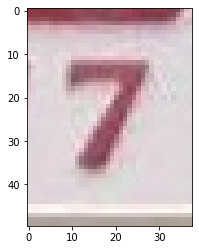

In [45]:
x = random.randint(0, len(gt_dict))
img_id = list(gt_dict.keys())[x]
test_img = mmcv.imread(f'{new_dir}images/{img_id}')
print (f'GT: {gt_dict[img_id]}')
plt.imshow(mmcv.bgr2rgb(test_img))
plt.show()

## Convert to LineJsonParser (Detection)

In [16]:
gt_jsons = os.listdir('gt')
train_gt_line, val_gt_line = [], []
new_dir = "line_json_parse/"
mmcv.mkdir_or_exist(new_dir)
mmcv.mkdir_or_exist(new_dir+'train/')
mmcv.mkdir_or_exist(new_dir+'val/')

train_lines, val_lines = [], []
for json_file in gt_jsons:
    gt = json.load(open(os.path.join('gt', json_file)))
    img_file = json_file.replace('.json', '.jpg')
    img = mmcv.imread(os.path.join('img', img_file))
    h, w, c = img.shape
    ann_list=[]
    
    for item in gt['chars']:
        ignore, text, points = item['ignore'], item['transcription'], item['points']
        x1, y1, x2, y2, x3, y3, x4, y4 = points
        min_x, max_x = min(x1, x2, x3, x4), max(x1, x2, x3, x4)
        min_y, max_y = min(y1, y2, y3 ,y4), max(y1, y2, y3, y4)
        bbox = [min_x, min_y, max_x - min_x, max_y - min_y]
#         # Visualize bbox crop
#         bbox_img = img[min_y:max_y, min_x:max_x]
#         plt.imshow(mmcv.bgr2rgb(bbox_img))
#         plt.show()

        ann = dict(
            iscrowd=ignore,
            category_id=1,
            bbox=bbox,
            segmentation=[points],            
        )
        ann_list.append(ann)
    
    line = dict(
        file_name=img_file,
        height=h,
        width=w,
        annotations=ann_list
    )
    if img_files.index(img_file) in train_arr:
        train_lines.append(json.dumps(line) + '\n')
    else:
        val_lines.append(json.dumps(line) + '\n')
    
f = open(f'{new_dir}/train/labels.txt', 'w')
f.writelines(train_lines)
f.close()
f = open(f'{new_dir}/val/labels.txt', 'w')
f.writelines(val_lines)
f.close()
print ('done')

done


In [17]:
f = open('line_json_parse/train/labels.txt')
for item in f:
    x = json.loads(item)
    break

In [20]:
print (x.keys())
for i in x['annotations']:
    print (i)

dict_keys(['file_name', 'height', 'width', 'annotations'])
{'iscrowd': 0, 'category_id': 1, 'bbox': [861, 124, 143, 131], 'segmentation': [[861, 124, 1004, 124, 1004, 255, 861, 255]]}
{'iscrowd': 0, 'category_id': 1, 'bbox': [734, 171, 117, 105], 'segmentation': [[734, 171, 851, 171, 851, 276, 734, 276]]}
{'iscrowd': 0, 'category_id': 1, 'bbox': [619, 192, 112, 104], 'segmentation': [[619, 192, 731, 192, 731, 296, 619, 296]]}
{'iscrowd': 0, 'category_id': 1, 'bbox': [555, 273, 64, 54], 'segmentation': [[555, 273, 619, 273, 619, 327, 555, 327]]}
{'iscrowd': 0, 'category_id': 1, 'bbox': [555, 214, 64, 60], 'segmentation': [[555, 214, 619, 214, 619, 274, 555, 274]]}
{'iscrowd': 0, 'category_id': 1, 'bbox': [462, 245, 92, 95], 'segmentation': [[462, 245, 554, 245, 554, 340, 462, 340]]}
{'iscrowd': 0, 'category_id': 1, 'bbox': [367, 272, 88, 87], 'segmentation': [[367, 272, 455, 272, 455, 359, 367, 359]]}
{'iscrowd': 0, 'category_id': 1, 'bbox': [288, 291, 76, 87], 'segmentation': [[288, 29